# Vežba 12 : Linearna regresija - Metode semplovanja, selekcija parametara i regularizacija

**Za potrebe reprodukovanja analize, treba instalirati paket ISLP (koji su kreirali autori knjige) u okruženje bio_ml!** Uputstvo za instaliranje, kao i podaci koji se koriste u knjizi su na [pratećem sajtu knjige](https://www.statlearning.com/resources-python). Iskoristite sledeće komande:

`conda activate bio_ml`

`pip install ISLP`

`pip install l0bnb`

`conda list ISLP`

**Praktikum reprodukuje primer** koda dat u poglavlju 3.6 "Lab: Linear Regression" u ISLP knjizi, sa idejom da se on iskoristi kao templejt za pisanje sličnog koda za analizu drugog seta podataka.

## Set podataka 

**abalone_dataset.csv** sadrži tabelu u kojoj se za svaku od 4177 jedinki školjke Petrovo uho (eng. abalone, Haliotis sp.) nalaze vrednosti 9 veličina kojima odgovaraju sledeći nazivi kolona:
1. `Length` (Longest shell measurement) in mm
2. `Diameter` (perpendicular to length) in mm
3. `Height` (with meat in shell) in mm
4. `Whole weight` (whole abalone) in grams
5. `Shucked weight` (weight of meat) in grams
6. `Viscera weight`	(gut weight after bleeding) in grams
7. `Shell weight` (after being dried) in grams
8. `Rings` (+1.5 gives the age in years) as integer values (celi brojevi)
9. `Sex` as categorical with values M (male), F (female), and I (infant)

Starost ovih školjki se određuje presecanjem ljušture i brojanjem prstenova na obojenom preseku pod mikroskopom. Ova kolekcija podataka je sastavljena sa ciljem da se ispita da li se druge karakteristike školjke koje je lakše izmeriti mogu iskoristiti za predviđanje broja prstenova, tj. starosti školjke.

## Cilj vežbe

Dati kod u sekcijama zadataka je anotiran sa njegovom funkcijom.

Neophodno je izmeniti i dopuniti postojeći kod kako bi radio sa abalone_dataset.csv setom podataka koji je opisan iznad.




## Zadatak 1 - Pristup validacionog skupa, Polinomska regresija i Unakrsna validacija (LOOCV, kFold)
U ovom zadatku vršimo podelu seta podataka na test i validacioni set i računamo MSE (srednju kvadratnu grešku) na validacionom setu podataka.

Nakon toga radimo regresiju za više modela sa polinomskim članom različitog stepena.

Na kraju radimo unakrsnu validaciju (Cross-Validation).

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm

from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize, poly)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate, KFold
from sklearn.linear_model import LinearRegression
from sklearn.utils import resample

# 1.1 Pristup validacionog skupa (The Validation Set Approach)
Neophodno je modifikovati set podataka na kome se radi. 

Zavisna varijabla (y_train, y_valid) treba da bude Rings kolona iz abalone_dataset.csv

Nezavisna varijabla treba da bude Shell weight kolona iz abalone_dataset.csv


In [12]:
# Učitavanje 'Auto' skupa podataka
abalone = pd.read_csv('abalone_dataset.csv')
abalone.drop('Sex', axis = 1, inplace = True)
# Podela podataka na trening i validacioni skup
# test_size=196 označava da 196 opservacija ide u validacioni skup
# random_state=0 osigurava ponovljivost rezultata pri svakom pokretanju
abalone_train, abalone_valid = train_test_split(abalone, test_size=196, random_state=0)

# Prilagođavanje modela linearne regresije koristeći samo trening skup
# Kreiranje specifikacije modela za 'horsepower' (konjske snage)
shellw_mm = MS(['Shell weight'])
# Transformacija trening podataka na osnovu specifikacije (dodaje presečnu tačku/intercept)
X_train = shellw_mm.fit_transform(abalone_train)
# Definisanje zavisne varijable (odziva) za trening ('mpg' - milja po galonu)
y_train = abalone_train['Rings']
# Inicijalizacija OLS (Ordinary Least Squares) modela
model = sm.OLS(y_train, X_train)
# Treniranje (fitovanje) modela na trening podacima
results = model.fit()

# Evaluacija modela na validacionom skupu
# Transformacija validacionih podataka koristeći istu specifikaciju
X_valid = shellw_mm.transform(abalone_valid)
# Definisanje zavisne varijable za validaciju
y_valid = abalone_valid['Rings']
# Generisanje predikcija za validacioni skup koristeći trenirani model
valid_pred = results.predict(X_valid)

# Izračunavanje i ispisivanje srednje kvadratne greške (MSE)
# Računanje proseka kvadrata razlika između stvarnih i predviđenih vrednosti
mse = np.mean((y_valid - valid_pred)**2)
# Ispisivanje rezultata MSE
print("MSE (Validacioni set - linearni):", mse)

MSE (Validacioni set - linearni): 5.960406286468561


## 1.2 Polinomska regresija sa validacijom
Potrebno je adaptirati imena kolona u eval_mse funkciji kao i imena varijabli koje se prosleđuju ovoj funkciji. 

In [13]:
# Funkcija za izračunavanje MSE za zadati stepen polinoma
def eval_mse(degree, train, valid):
    # Kreiranje specifikacije modela sa polinomskim članom zadatog stepena
    mm = MS([poly('Shell weight', degree=degree)]) 
    # Transformacija trening podataka
    X_train = mm.fit_transform(train)
    # Transformacija validacionih podataka
    X_valid = mm.transform(valid)
    # Izdvajanje zavisne varijable za trening
    y_train = train['Rings']
    # Izdvajanje zavisne varijable za validaciju
    y_valid = valid['Rings']
    
    # Treniranje OLS modela na trening podacima
    results = sm.OLS(y_train, X_train).fit()
    # Predviđanje vrednosti na validacionom skupu
    valid_pred = results.predict(X_valid)
    
    # Vraćanje izračunate srednje kvadratne greške (MSE)
    return np.mean((y_valid - valid_pred)**2)

# Izračunavanje MSE za polinome stepena 1, 2 i 3
mse_degree_1 = eval_mse(1, abalone_train, abalone_valid) # Linearni model
mse_degree_2 = eval_mse(2, abalone_train, abalone_valid) # Kvadratni model
mse_degree_3 = eval_mse(3, abalone_train, abalone_valid) # Kubni model

# Ispisivanje MSE vrednosti za poređenje
print("MSE za stepene 1, 2, 3:", mse_degree_1, mse_degree_2, mse_degree_3)

MSE za stepene 1, 2, 3: 5.960406286468562 5.672275669950117 5.609854875607115


## 1.3 Unakrsna validacija (Cross-Validation) 
Potrebno je adaptirati imena kolona koje se koriste za treniranje lineranog modela.

Zavisna varijabla (y_train, y_valid) treba da bude Rings kolona iz abalone_dataset.csv

Nezavisna varijabla treba da bude Shell weight kolona iz abalone_dataset.csv

In [24]:
# Priprema podataka za sklearn (koristeći ceo skup podataka jer CV radi podelu automatski)
hp_model = MS(['Shell weight'])
# Transformacija svih prediktora
X = hp_model.fit_transform(abalone)
# Izdvajanje zavisne varijable iz celog skupa
y = abalone['Rings']
# Inicijalizacija modela linearne regresije iz scikit-learn biblioteke
model = LinearRegression()

# Unakrsna validacija "izostavi-jedan" (Leave-One-Out Cross-Validation - LOOCV)
# Koristimo KFold gde je broj podela (splits) jednak ukupnom broju opservacija
cv = KFold(n_splits=len(X), shuffle=True, random_state=0)
# Izvođenje unakrsne validacije; scoring='neg_mean_squared_error' vraća negativni MSE
cv_results = cross_validate(model, X, y, cv=cv, scoring='neg_mean_squared_error')
# Računanje prosečnog MSE (menjamo znak jer sklearn vraća negativne vrednosti)
loocv_mse = -np.mean(cv_results['test_score'])
# Ispisivanje rezultata LOOCV
print('LOOCV MSE:', loocv_mse)

# k-Fold unakrsna validacija (npr. k=10)
# Definisanje 10-struke podele (10-fold splitter)
cv_10 = KFold(n_splits=10, shuffle=True, random_state=0)
# Izvođenje 10-struke unakrsne validacije
cv_results_10 = cross_validate(model, X, y, cv=cv_10, scoring='neg_mean_squared_error')
# Računanje prosečnog MSE za 10-struku validaciju
kfold_mse = -np.mean(cv_results_10['test_score'])
# Ispisivanje rezultata 10-Fold CV
print('10-Fold CV MSE:', kfold_mse)

LOOCV MSE: 6.306480022647931
10-Fold CV MSE: 6.3080007657062085


## Zadatak 2 - Selekcija nezavisnih prediktora (Forward selection)
U ovom zadatku vršimo selekciju nezavisnih prediktora na abalone_dataset.csv.

Potrebno je adaptirati kod da zavisna varijabla "Y" treba da bude "Rings" kolona iz abalone_dataset.csv dok sve preostale varijable iz abalone_dataset.csv (sem "Sex" kolone) trebaju da budu nezavisne varijable.

Za kriterijum selekcije prediktora prvo koristimo scoring="neg_mean_squared_error".

Zatim koristimo Mallows Cp kriterijum definisan u funkciji nCP.

Mallows Cp je kriterijum za izbor modela u linearnoj regresiji koji se koristi za biranje između konkurentskih modela tako što uravnotežuje kvalitet prilagođavanja (dobrotu uklapanja) i složenost modela. Njegova osnovna svrha je procena očekivane greške na test skupu bez eksplicitne upotrebe unakrsne validacije.




In [15]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

from matplotlib.pyplot import subplots
from statsmodels.api import OLS
import sklearn.model_selection as skm
import sklearn.linear_model as skl
from sklearn.preprocessing import StandardScaler
from ISLP import load_data
from ISLP.models import ModelSpec as MS
from functools import partial
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from ISLP.models import (Stepwise, sklearn_selected, sklearn_selection_path)
from sklearn.preprocessing import StandardScaler


In [16]:
from l0bnb import fit_path

In [ ]:
#Hitters = load_data('Hitters') # Učitavanje "Hitters" skupa podataka
#np.isnan(Hitters['Salary']).sum() # Računa ukupan broj nedostajućih vrednosti u koloni 'Salary'
#Hitters = Hitters.dropna() # Uklanja sve redove koji sadrže nedostajuće vrednosti
#Hitters.shape # Prikazuje dimenzije pročišćenog skupa podataka

In [25]:
def nCp(sigma2, estimator, X, Y):
    "Negative Cp statistic"
    n, p = X.shape # Dobija broj uzoraka (n) i broj prediktora (p)
    Yhat = estimator.predict(X) # Generiše predviđanja na osnovu estimatora
    RSS = np.sum((Y - Yhat)**2) # Računa sumu kvadrata reziduala (RSS)
    return -(RSS + 2 * p * sigma2) / n # Vraća negativnu Cp statistiku (jer sklearn maksimizuje skor)

In [30]:
design = MS(abalone.columns.drop('Rings')).fit(abalone) # Kreira dizajn matricu isključujući ciljnu promenljivu 'Salary'
Y = np.array(abalone['Rings']) # Izdvaja ciljnu promenljivu Y kao niz
X = design.transform(abalone) # Transformiše podatke u matricu prediktora X
sigma2 = OLS(Y,X).fit().scale # Prilagođava OLS model na svim podacima da bi se procenila varijansa šuma (sigma2)

In [31]:
neg_Cp = partial(nCp, sigma2) # Kreira novu funkciju skorovanja sa fiksiranim parametrom sigma2 (procenjena varijansa šuma)

In [32]:
strategy = Stepwise.first_peak(design, direction='forward', max_terms=len(design.terms)) # Definiše strategiju postupnog izbora (forward selection) koja staje na prvom piku

In [36]:
abalone_MSE = sklearn_selected(OLS, strategy, scoring="neg_mean_squared_error") # Inicijalizuje selektor modela koristeći OLS i definisanu strategiju (podrazumevano koristi MSE)
abalone_MSE.fit(abalone, Y) # Pokreće proces selekcije na podacima
abalone_MSE.selected_state_ # Prikazuje izabrane promenljive (trebalo bi da budu sve ako se koristi MSE)

('Diameter',
 'Height',
 'Length',
 'Shell weight',
 'Shucked weight',
 'Viscera weight',
 'Whole weight')

In [35]:
abalone_Cp = sklearn_selected(OLS, strategy, scoring=neg_Cp) # Inicijalizuje selektor modela koristeći negativni Cp kao kriterijum
abalone_Cp.fit(abalone, Y) # Pokreće proces selekcije
abalone_Cp.selected_state_ # Prikazuje izabrane promenljive prema Cp kriterijumu

('Diameter',
 'Height',
 'Shell weight',
 'Shucked weight',
 'Viscera weight',
 'Whole weight')

## Zadatak 3 - Ridge i Lasso regresija - optimizacija lambda parametra sa unakrsnom validacijom

Potrebno je adaptirati kod da zavisna varijabla "Y" treba da bude "Rings" kolona iz abalone_dataset.csv dok sve preostale varijable iz abalone_dataset.csv (sem "Sex" kolone) trebaju da budu nezavisne varijable.

In [37]:
D = design.fit_transform(abalone) # Priprema dizajn matricu
X = np.asarray(D) 
scaler = StandardScaler(with_mean=True, with_std=True) # Skaliranje ulaynih podataka
X_s = scaler.fit_transform(X)
lambdas = 10**np.linspace(8, -2, 100) / Y.std() # Generiše niz lambda vrednosti (hiperparametara) skaliranih devijacijom Y
soln_array = skl.ElasticNet.path(X_s, Y, l1_ratio=0, alphas=lambdas)[1] # Računa putanju rešenja za Ridge regresiju (l1_ratio=0)
soln_array.shape # Prikazuje dimenzije rešenja

(8, 100)

In [38]:
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas)) # Kreira DataFrame sa koeficijentima za lakše plotovanje
soln_path.index.name = 'negative log(lambda)' # Imenuje indeks DataFrame-a
soln_path # Prikazuje DataFrame

,intercept,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight
negative log(lambda),,,,,,,,
-17.250125,0.0,5.785861e-08,5.972311e-08,5.793633e-08,5.616148e-08,4.374149e-08,5.236080e-08,6.522236e-08
-17.017541,0.0,7.300929e-08,7.536201e-08,7.310735e-08,7.086775e-08,5.519550e-08,6.607183e-08,8.230128e-08
-16.784957,0.0,9.212726e-08,9.509606e-08,9.225101e-08,8.942495e-08,6.964881e-08,8.337319e-08,1.038524e-07
-16.552372,0.0,1.162514e-07,1.199976e-07,1.164076e-07,1.128415e-07,8.788682e-08,1.052050e-07,1.310469e-07
-16.319788,0.0,1.466926e-07,1.514198e-07,1.468897e-07,1.423898e-07,1.109006e-07,1.327537e-07,1.653624e-07
...,...,...,...,...,...,...,...,...
4.845388,0.0,1.369162e-02,1.077650e+00,5.200418e-01,2.068498e+00,-3.229946e+00,-5.191937e-01,1.940834e+00
5.077973,0.0,-1.664909e-02,1.114743e+00,5.156116e-01,2.331994e+00,-3.380353e+00,-5.769253e-01,1.875107e+00
5.310557,0.0,-4.420196e-02,1.148260e+00,5.118512e-01,2.593823e+00,-3.523393e+00,-6.349310e-01,1.804105e+00


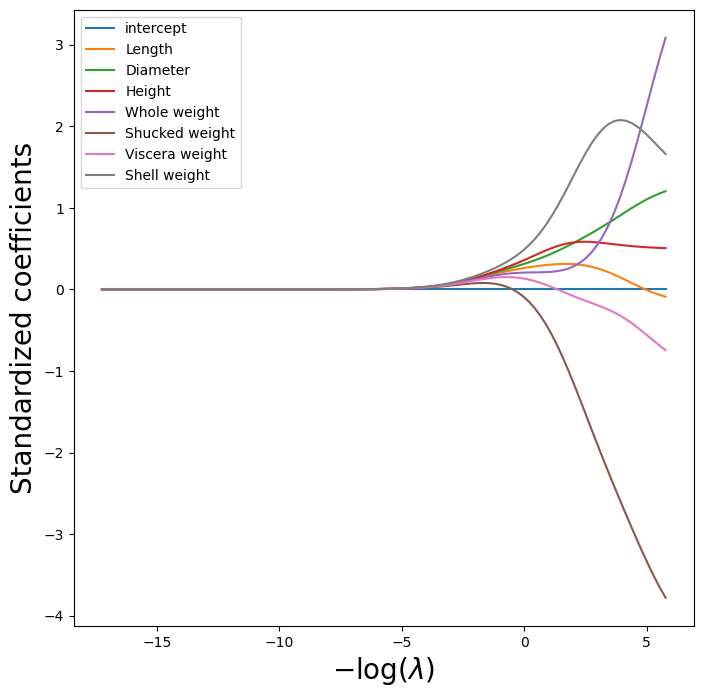

In [39]:
path_fig, ax = subplots(figsize=(8,8)) # Kreira figuru za grafik
soln_path.plot(ax=ax, legend=False) # Iscrtava promene koeficijenata u zavisnosti od lambde
ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Postavlja oznaku x-ose (koristi LaTeX formatiranje)
ax.set_ylabel('Standardized coefficients', fontsize=20) # Postavlja oznaku y-ose
ax.legend(loc='upper left') # Postavlja legendu u gornji levi ugao

In [40]:
beta_hat = soln_path.loc[soln_path.index[39]] # Izdvaja koeficijente za 40-ti korak
lambdas[39], beta_hat # Prikazuje lambda vrednost i koeficijente tog koraka

(np.float64(3566.483761229299),
 intercept         0.000000
 Length            0.000502
 Diameter          0.000519
 Height            0.000503
 Whole weight      0.000488
 Shucked weight    0.000380
 Viscera weight    0.000455
 Shell weight      0.000566
 Name: -8.1793354485686, dtype: float64)

In [41]:
np.linalg.norm(beta_hat) # Računa L2 normu koeficijenata za izabrani model

np.float64(0.0012975244983926594)

In [42]:
beta_hat = soln_path.loc[soln_path.index[59]] # Izdvaja koeficijente za 60-ti korak (manja lambda)
lambdas[59], np.linalg.norm(beta_hat) # Prikazuje lambda vrednost i veću L2 normu

(np.float64(34.04381569990923), np.float64(0.11505553505972768))

In [43]:
ridge = skl.ElasticNet(alpha=lambdas[59], l1_ratio=0) # Inicijalizuje Ridge model sa specifičnom lambdom
scaler = StandardScaler(with_mean=True, with_std=True) # Inicijalizuje skaler za standardizaciju podataka
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)]) # Kreira pajplajn koji prvo skalira pa primenjuje Ridge
pipe.fit(X, Y) # Trenira pajplajn na podacima

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(34.04381569990923)
,l1_ratio,0
,fit_intercept,True
,precompute,False


In [ ]:
np.linalg.norm(ridge.coef_) # Proverava L2 normu koeficijenata iz pajplajna (treba da se poklapa)

In [44]:
validation = skm.ShuffleSplit(n_splits=1, test_size=0.5, random_state=0) # Kreira validacioni split (50/50)
ridge.alpha = 0.01 # Postavlja proizvoljnu vrednost za lambda (alpha)
results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation) # Izvršava validaciju i računa negativni MSE
-results['test_score'] # Prikazuje pozitivan MSE

array([6.24716562])

In [45]:
ridge.alpha = 1e10 # Postavlja ogromnu vrednost za lambda (teži ka nultom modelu)
results = skm.cross_validate(ridge, X, Y, scoring='neg_mean_squared_error', cv=validation) # Izvršava validaciju
-results['test_score'] # Prikazuje MSE (koji bi trebao biti sličan varijansi Y)

array([10.38007843])

In [46]:
param_grid = {'ridge__alpha': lambdas} # Definiše mrežu parametara za pretragu (lambdas)
grid = skm.GridSearchCV(pipe, param_grid, cv=validation, scoring='neg_mean_squared_error') # Inicijalizuje pretragu na mreži (Grid Search) sa validacionim setom
grid.fit(X, Y) # Pokreće pretragu da nađe najbolju lambdu
grid.best_params_['ridge__alpha'] # Prikazuje najbolju pronađenu vrednost za lambda
grid.best_estimator_ # Prikazuje najbolji estimator (ceo pajplajn)

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(0....1945694181704)
,l1_ratio,0
,fit_intercept,True
,precompute,False


In [47]:
K = 5
kfold = skm.KFold(K,
random_state=0,
shuffle=True)

grid = skm.GridSearchCV(pipe, param_grid, cv=kfold, scoring='neg_mean_squared_error') # Inicijalizuje Grid Search koristeći 5-fold unakrsnu validaciju
grid.fit(X, Y) # Pokreće pretragu
grid.best_params_['ridge__alpha'] # Prikazuje najbolju lambdu prema CV
grid.best_estimator_ # Prikazuje najbolji estimator

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,alpha,np.float64(0....1945694181704)
,l1_ratio,0
,fit_intercept,True
,precompute,False


Text(0, 0.5, 'Cross-validated MSE')

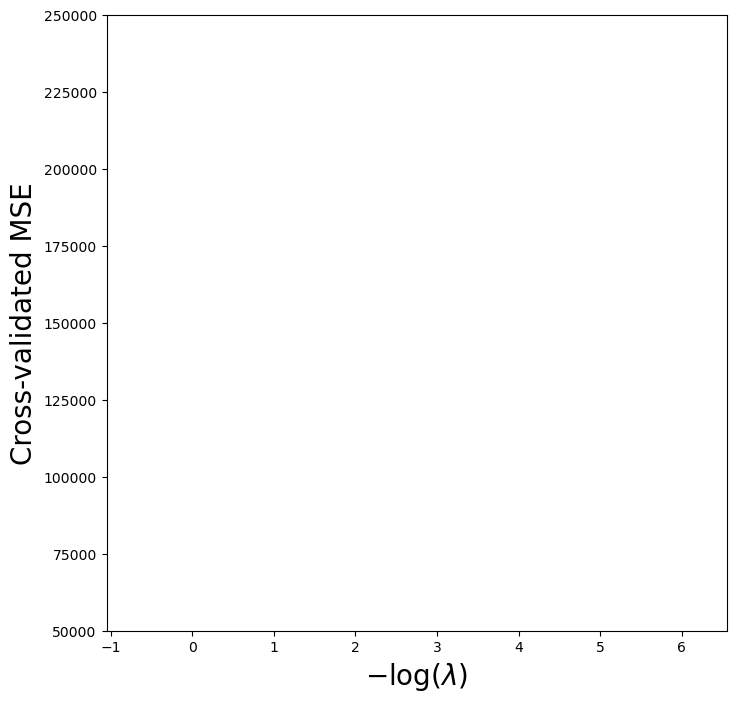

In [63]:
ridge_fig, ax = subplots(figsize=(8,8)) # Kreira figuru
ax.errorbar(-np.log(lambdas), -grid.cv_results_['mean_test_score'], yerr=grid.cv_results_['std_test_score'] / np.sqrt(K)) # Iscrtava CV greške sa standardnim greškama
ax.set_ylim([50000, 250000]) # Postavlja limite y-ose
ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Postavlja oznaku x-ose
ax.set_ylabel('Cross-validated MSE', fontsize=20) # Postavlja oznaku y-ose

In [49]:
grid_r2 = skm.GridSearchCV(pipe, param_grid, cv=kfold) # Inicijalizuje Grid Search koristeći podrazumevani R2 skor
grid_r2.fit(X, Y) # Pokreće pretragu

,estimator,Pipeline(step...l1_ratio=0))])
,param_grid,{'ridge__alpha': array([3.1019...10194569e-03])}
,scoring,None
,n_jobs,None
,refit,True
,cv,KFold(n_split... shuffle=True)
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,copy,True


Text(0, 0.5, 'Cross-validated $R^2$')

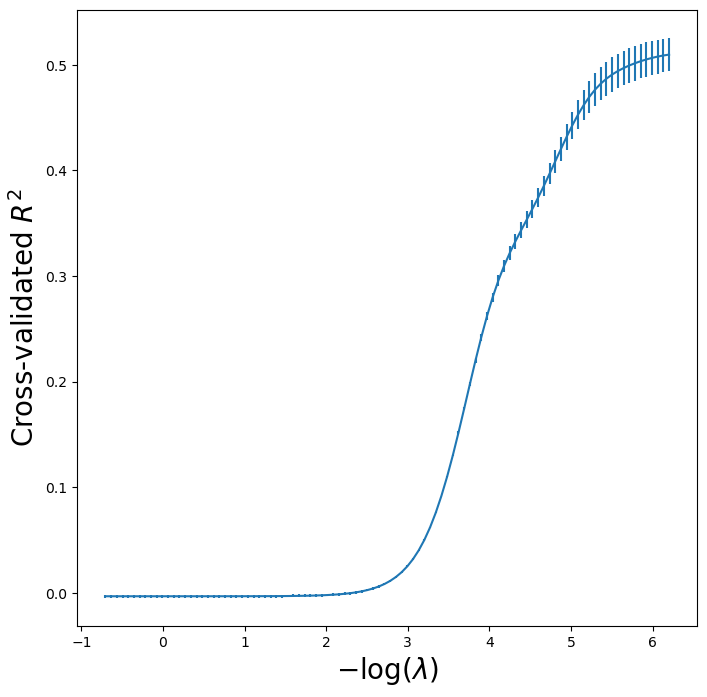

In [64]:
r2_fig, ax = subplots(figsize=(8,8)) # Kreira figuru za R2 grafik
ax.errorbar(-np.log(lambdas), grid_r2.cv_results_['mean_test_score'], yerr=grid_r2.cv_results_['std_test_score'] / np.sqrt(K)) # Iscrtava R2 skorove
ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Oznaka x-ose
ax.set_ylabel('Cross-validated $R^2$', fontsize=20) # Oznaka y-ose

In [68]:
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=kfold) # Koristi efikasniju ugrađenu CV funkciju za Ridge
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)]) # Pravi pajplajn sa RidgeCV
pipeCV.fit(X, Y) # Trenira pajplajn

,steps,"[('scaler', ...), ('ridge', ...)]"
,transform_input,None
,memory,None
,verbose,False
,copy,True
,with_mean,True
,with_std,True
,l1_ratio,0
,eps,0.001
,n_alphas,'deprecated'
,alphas,"array([2.0231..., 0.00202316])"


Text(0, 0.5, 'Cross-validated MSE')

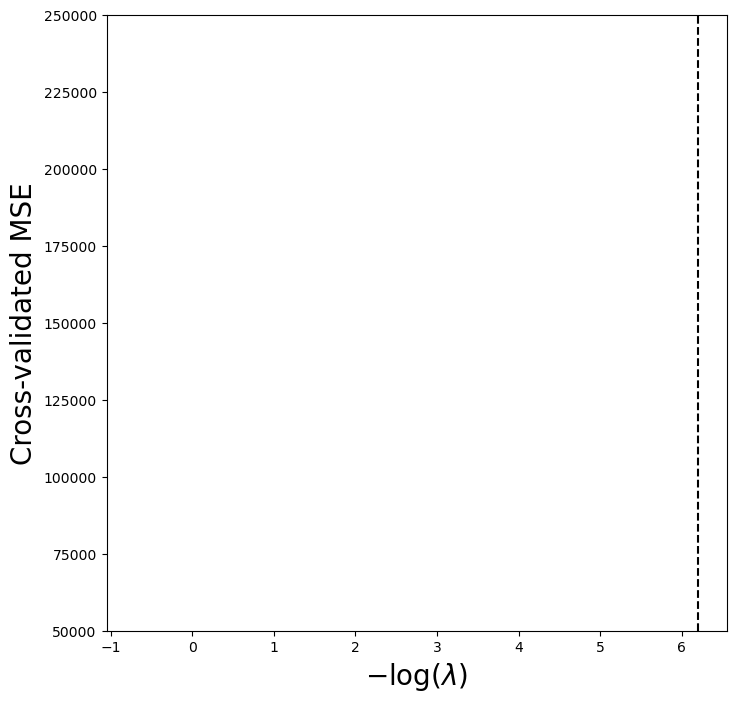

In [69]:
tuned_ridge = pipeCV.named_steps['ridge'] # Izdvaja istrenirani Ridge model iz pajplajna
ridgeCV_fig, ax = subplots(figsize=(8,8)) # Kreira figuru
ax.errorbar(-np.log(lambdas), tuned_ridge.mse_path_.mean(1), yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K)) # Iscrtava putanju MSE grešaka
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--') # Označava vertikalnom linijom izabranu optimalnu lambdu
ax.set_ylim([50000, 250000]) # Limiti y-ose
ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Oznaka x-ose
ax.set_ylabel('Cross-validated MSE', fontsize=20) # Oznaka y-ose

In [54]:
np.min(tuned_ridge.mse_path_.mean(1)) # Prikazuje minimalnu srednju MSE vrednost sa putanje

np.float64(5.090854084712624)

In [55]:
tuned_ridge.coef_ # Prikazuje koeficijente modela za optimalnu lambdu (svi su različiti od nule kod Ridge-a)

array([ 0.        , -0.08985245,  1.20372208,  0.50605515,  3.08565597,
       -3.78001905, -0.74528759,  1.66016639])

In [56]:
outer_valid = skm.ShuffleSplit(n_splits=1, test_size=0.25, random_state=1) # Definisanje spoljašnjeg validacionog splita
inner_cv = skm.KFold(n_splits=5, shuffle=True, random_state=2) # Definisanje unutrašnje CV petlje
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=inner_cv) # Definisanje modela sa unutrašnjom CV
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)]) # Kreiranje pajplajna
results = skm.cross_validate(pipeCV, X, Y, cv=outer_valid, scoring='neg_mean_squared_error') # Izvršavanje ugnježdene validacije
-results['test_score'] # Prikaz rezultujućeg MSE-a

array([4.90158962])

In [57]:
lassoCV = skl.ElasticNetCV(n_alphas=100, l1_ratio=1, cv=kfold) # Inicijalizuje CV za Lasso (l1_ratio=1)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)]) # Kreira pajplajn za Lasso
pipeCV.fit(X, Y) # Trenira Lasso model
tuned_lasso = pipeCV.named_steps['lasso'] # Izdvaja Lasso model
tuned_lasso.alpha_ # Prikazuje optimalnu lambdu za Lasso

/home/olivera2808/miniforge3/envs/bio_ml/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:1622: FutureWarning: 'n_alphas' was deprecated in 1.7 and will be removed in 1.9. 'alphas' now accepts an integer value which removes the need to pass 'n_alphas'. The default value of 'alphas' will change from None to 100 in 1.9. Pass an explicit value to 'alphas' and leave 'n_alphas' to its default value to silence this warning.
  warnings.warn(


np.float64(0.0020231625772413023)

In [58]:
lambdas, soln_array = skl.Lasso.path(X_s, Y, l1_ratio=1, n_alphas=100)[:2] # Računa putanju rešenja za Lasso
soln_path = pd.DataFrame(soln_array.T, columns=D.columns, index=-np.log(lambdas)) # Kreira DataFrame koeficijenata

Text(0, 0.5, 'Standardized coefficients')

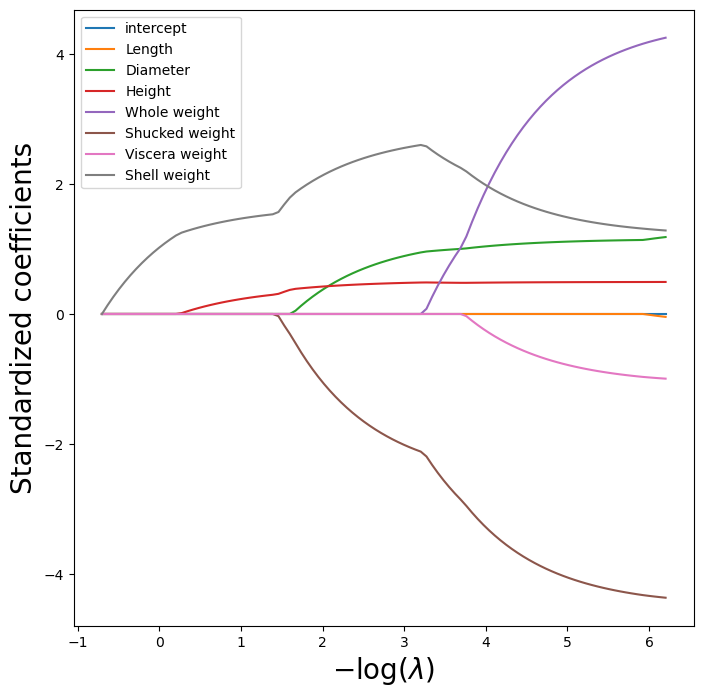

In [59]:
path_fig, ax = subplots(figsize=(8,8)) # Kreira figuru
soln_path.plot(ax=ax, legend=False) # Iscrtava Lasso putanju
ax.legend(loc='upper left') # Legenda
ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Oznaka x-ose
ax.set_ylabel('Standardized coefficients', fontsize=20) # Oznaka y-ose

In [60]:
np.min(tuned_lasso.mse_path_.mean(1)) # Prikazuje minimalni MSE za Lasso

np.float64(5.065591812694358)

Text(0, 0.5, 'Cross-validated MSE')

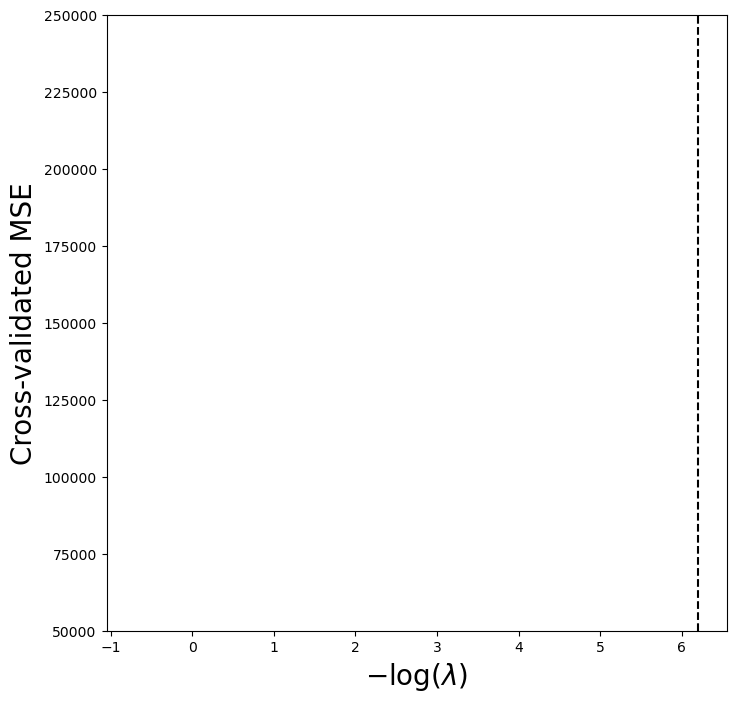

In [61]:
lassoCV_fig, ax = subplots(figsize=(8,8)) # Kreira figuru za CV grešku Lasso-a
ax.errorbar(-np.log(tuned_lasso.alphas_), tuned_lasso.mse_path_.mean(1), yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K)) # Iscrtava greške
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--') # Označava optimalnu lambdu
ax.set_ylim([50000, 250000]) # Limiti y-ose
ax.set_xlabel('$-\log(\lambda)$', fontsize=20) # Oznaka x-ose
ax.set_ylabel('Cross-validated MSE', fontsize=20) # Oznaka y-ose

In [62]:
tuned_lasso.coef_ # Prikazuje koeficijente Lasso modela (mnogi su nula - sparse model)

array([ 0.        , -0.04480179,  1.18238304,  0.49220871,  4.24570694,
       -4.36081118, -0.99389501,  1.28349297])